In [1]:
%matplotlib inline
from IPython.display import Image

## This directory simulate tides in Grays Harbor, WA, using boundary conditions. 

### First, a sine tidal signal is implemented on the left boundary to get 

1.The high tide time lag between the boundary and NOAA station 1102 at Westport   

2.The high tide amplitude at NOAA station 1102

### Second, simulates the King Tide event from December, 2015

The left boundary condition is implemented using the existing NOAA 1102 tides prediction data, but the data is shifted by the time lag and divided by the amplitude observed in sine boundary condition example.

The topography is shown below:

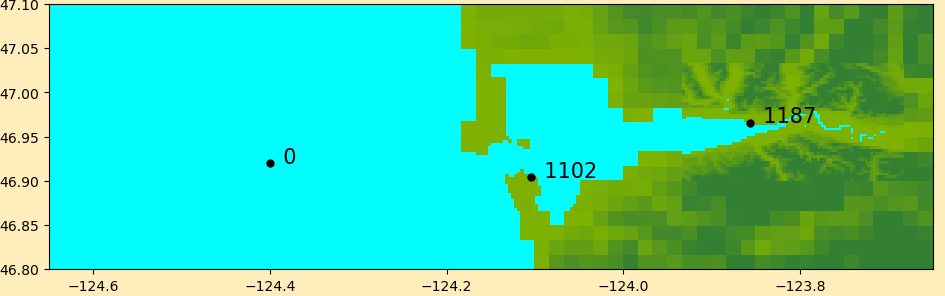

In [2]:
Image('domain1.png', width=800)

### The project follows from https://github.com/rjleveque/geoclaw_tides/tree/main/GraysHarbor
In Dr. Randall Leveque's example, the tides are forced inside the domain, the boundary condition is implemented as zero-order extrapolation.

The maximal tidal forcing is implemented from longitude -124.7 to -124.4 and a linear tapered forcing is implemented from longitude -124.3 to -124.19.

The graph is shown below:

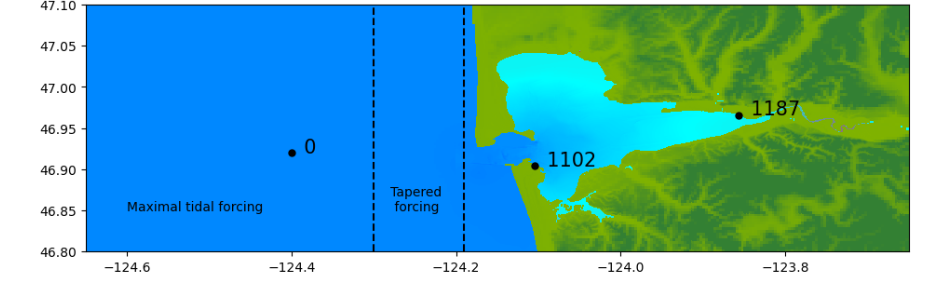

In [3]:
Image('domain2.PNG', width=800)

### Simple and Riemann

We explore two ways of implementing a tidal signal at the boundary, we call the two ways Simple and Riemann

Geoclaw breaks the domain into smaller rectangle cells, label them $ (i,j)$  in terms of locations, define 

$ s(t): $ tidal signal 

val$ (1, i, j):$  water height on $ (i,j)$ cell

val$ (2, i, j):$  velocity in x direction on $ (i,j)$ cell

val$ (3, i, j):$  velocity in y direction on $ (i,j)$ cell

$\Delta t:$ next jump in time

### Simple
(i, j) is the boundary ghost cell

jump_h$=  (s(t + \Delta t) - s(t))$.

#### Code:

val(1, i, j) = val(1, i + 1, j) + jump_h

val(2, i, j) = val(2, i + 1, j)

val(3, i, j) = 0

It's implemented in ./SimpleGraysHarbor directory

### Riemann

Geoclaw uses shallow water Riemann solver, so this method sets $h_m - h_r$ in the Riemann problem as the tidal signal.

Ignore the velocity in y direction (since tidal signal is traveling not in the y direction), 1D shallow water equations are 


$\begin{aligned} h_{t}+(h u)_{x} &=0 \\(h u)_{t}+\left(h u^{2}+\frac{1}{2} g h^{2}\right)_{x} &=0 . \end{aligned}$




The Riemann problem for 1D shallow water equations involve giving $q_{l}$ and $q_{r}$, solve for $q_{m}$


$q_{l}=\left[\begin{array}{c}h_{l} \\ u_{l}h_{l} \end{array}\right],\quad q_{m}=\left[\begin{array}{c}h_{m} \\  u_{m}h_{m}\end{array}\right], \quad q_{r}=\left[\begin{array}{c}h_{r} \\ u_{r}h_{r} \end{array}\right]$

In our example, $q_{l}$ is the values of the ghost cell that we want to implement, $q_{r}$ is the information given inside the physical domain next to the ghost cell. 

We assume $h_m - h_r = $ jump_h $=  (s(t + \Delta t) - s(t))$.

So in our example, the question is, given $q_r$, set $q_l$ such that $h_m = h_r +$ jump_h, we also want the 1-wave to not travel to the right. 

The solution is not unique, the easiest way is to find the unique $u_m$, then set $q_l = q_m$. 

A website is attached below which is an interactive view of the Riemann problem, it lets you set $q_l$, $q_r$ and see $q_m$

http://www.clawpack.org/riemann_book/phase_plane/shallow_water_small.html


##### Solve $u_m$
Case 1: $h_{m}>h_{r}$

By Lax entropy condition, we have a 2-shock if $h_{m}>h_{r}$

For a shock wave moving at speed $s$, Rankine--Hugoniot jump conditions gives

$$\begin{aligned} s\left(h_{r}-h_{m}\right) &=h_{r} u_{r}-h_{m} u_{m} \\ s\left(h_{r} u_{r}-h_{m} u_{m}\right) &=h_{r} u_{r}^{2}-h_{m} u_{m}^{2}+\frac{g}{2}\left(h_{r}^{2}-h^{2}\right) \end{aligned}$$


Combine the two equations, let $\alpha = h_m - h_r$

$$u_{m}=\frac{h_{r} u_{r}+\alpha\left[u_{r}-\sqrt{g h_{r}\left(1+\frac{\alpha}{h_{r}}\right)\left(1+\frac{\alpha}{2 h_{r}}\right)}\right].}{h_{m}}$$


Case 2: $h_{m} < h_{r}$

It's 2-rarefaction, since the variation within the rarefaction wave is at all points proportional to the corresponding eigenvector $r_p$, the solution can be found by solving $\tilde{q}^{\prime}(\xi)= r^{p}(\tilde{q}(\xi))$, where $\tilde{q}(\xi)$ is a parameterization of the solution

The eigenvectors are $r^{1}=\left[\begin{array}{c}1 \\ u-\sqrt{g h}\end{array}\right], \quad r^{2}=\left[\begin{array}{c}1 \\ u+\sqrt{g h}\end{array}\right]$

Consider $r^{1}$, then $\tilde{q}^{\prime}(\xi)= r^{p}(\tilde{q}(\xi))$ is



$$\begin{aligned} h^{\prime}(\xi) &=q_{1}^{\prime}(\xi)=1 \\(h u)^{\prime}(\xi) &=q_{2}^{\prime}(\xi)=u \pm \sqrt{g h}=\tilde{q}_{2} / \tilde{q}_{1}-\sqrt{g \tilde{q}_{1}} \end{aligned}$$


Fixing $(u_r,u_r h_r)$,

$$ u_{m}= \frac{h_{m} u_{r}-2 h_{r}\left(\sqrt{g h_{r}}-\sqrt{g h_{m}}\right)}{h_{m}}$$


So the logic of setting ghost cells goes like this,

#### Code:

jump_h$=  (s(t + \Delta t) - s(t))$.

val(3, i, j) = 0

val(1, i, j) = val(1, nxl + 1, j) + jump_h

h_r = val(1, nxl + 1, j)

h_m = val(1, i, j)

u_r = val(2, nxl + 1, j)

if (h_r < h_m)

    val(2, i, j) = (h_r*u_r + jump_h*(u_r - sqrt(9.81*h_r*(1+jump_h/h_r)*(1+jump_h/(2*h_r)))))/h_m
                      
else

    val(2, i, j) = (h_m*u_r - 2*h_r*(sqrt(9.81*h_r)-sqrt(9.81*h_m)))/h_m
    
    

It's implemented in ./RiemannGraysHarbor directory